This notebook follows the last one on data preprocessing and initial training. In this notebook, several models will be applied with cross validation on the training dataset. Hyperparameters will be tuned. The best model will be selected based on the metrics most relevant in the context of diabetes detection. Final model will be evaluated against test dataset.

In [1]:
#conda install -c conda-forge xgboost

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,cross_validate
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

from datetime import datetime

In [3]:
# import data
X_train = pd.read_csv('../data/processed/X_train',index_col = 0)
y_train = pd.read_csv('../data/processed/y_train',index_col = 0)
X_test = pd.read_csv('../data/processed/X_test',index_col = 0)
y_test = pd.read_csv('../data/processed/y_test',index_col = 0)

1. Gradien Boosting

In [4]:
start = datetime.now()
gb = GradientBoostingClassifier()
params = {'n_estimators': [20,50,100,200]
          , 'learning_rate' : [0.05, 0.1, 0.25, 0.5, 0.75, 1]
          , 'max_features' :['auto', 'sqrt', 'log2']
          , 'max_depth' : np.arange(1,10)}

rs_r = RandomizedSearchCV(gb, params, cv = 5, n_iter = 10, scoring = 'recall', random_state = 0)

rs_r.fit(X_train,y_train.values.ravel())
end = datetime.now()
print('{} execution time'.format(end - start))

rs_a = RandomizedSearchCV(gb, params, cv = 5, n_iter = 10, scoring = 'accuracy', random_state = 0)
rs_p = RandomizedSearchCV(gb, params, cv = 5, n_iter = 10, scoring = 'precision', random_state = 0)
rs_a.fit(X_train,y_train.values.ravel())
rs_p.fit(X_train,y_train.values.ravel())

0:00:05.315747 execution time


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(),
                   param_distributions={'learning_rate': [0.05, 0.1, 0.25, 0.5,
                                                          0.75, 1],
                                        'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [20, 50, 100, 200]},
                   random_state=0, scoring='precision')

In [5]:
print('accuracy: best parameters are {0}, score is {1}'.format(rs_a.best_params_,rs_a.best_score_))
print('precision: best parameters are {0}, score is {1}'.format(rs_p.best_params_,rs_p.best_score_))
print('recall: best parameters are {0}, score is {1}'.format(rs_r.best_params_,rs_r.best_score_))

accuracy: best parameters are {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 4, 'learning_rate': 0.75}, score is 0.9807515777395295
precision: best parameters are {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 4, 'learning_rate': 0.75}, score is 0.992153846153846
recall: best parameters are {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 4, 'learning_rate': 0.75}, score is 0.9843137254901961


Our goal is to early predict diabetes so actions can be taken to try to prevent it, it's more important to detect the positive when it is truly positive, thus recall will be the primary score and parameters selected using recall will be the used to refit the model later.

2. XGBoost

In [6]:
start = datetime.now()
xgbc = XGBClassifier()
params = {'max_depth': np.arange(1,10)
         , 'learning_rate': [0.05, 0.1, 0.25, 0.5, 0.75, 1]
         , 'n_estimators': [20,50,100,200]
         , 'colsample_bytree':[0.3,0.7]
         , 'subsample': [0.8,0.9,1.0]}
rs_r = RandomizedSearchCV(xgbc, params, cv = 5, n_iter = 10, scoring = 'recall', random_state = 0)
rs_r.fit(X_train,y_train.values.ravel())
end = datetime.now()
print('{} execution time'.format(end - start))

0:00:01.740044 execution time


In [7]:
print('recall: best parameters are {0}, score is {1}'.format(rs_r.best_params_,rs_r.best_score_))

recall: best parameters are {'subsample': 0.9, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.7}, score is 0.9765460030165913


3. Random Forest

In [8]:
start = datetime.now()
rf = RandomForestClassifier()
params = {'criterion': ['gini', 'entropy']
          , 'max_features': ['auto', 'sqrt', 'log2']
             ,'max_depth': np.arange(1,10)}
rs_r = RandomizedSearchCV(rf, params, cv = 5, n_iter = 10, scoring = 'recall', random_state = 0)
rs_r.fit(X_train,y_train.values.ravel())
end = datetime.now()
print('{} execution time'.format(end - start))

0:00:08.784705 execution time


In [9]:
print('recall: best parameters are {0}, score is {1}'.format(rs_r.best_params_,rs_r.best_score_))

recall: best parameters are {'max_features': 'log2', 'max_depth': 9, 'criterion': 'entropy'}, score is 0.9765460030165911


4. KNN

In [10]:
# KNN is distance based algorithm, thus 'Age' column needs to be tranformed first. 
mm = MinMaxScaler()
mm_X_train = mm.fit_transform(X_train)

In [11]:
start = datetime.now()
knn = KNeighborsClassifier()
params = {'n_neighbors' : np.arange(1,10)
         , 'weights' : ['uniform', 'distance'] }
rs_r = RandomizedSearchCV(knn, params, cv = 5, n_iter = 10, scoring = 'recall')
rs_r.fit(mm_X_train,y_train.values.ravel())
end = datetime.now()
print('{} execution time'.format(end - start))

0:00:00.255345 execution time


In [12]:
print('recall: best parameters are {0}, score is {1}'.format(rs_r.best_params_,rs_r.best_score_))

recall: best parameters are {'weights': 'distance', 'n_neighbors': 1}, score is 0.9607843137254903


5. Final Model Selection
<br> KNN's recall score is trailing behind the other three methods, with 96% compared to 98%.
<br> XGBoost is faster to train compared with GradientBoosting and RandomForest. But training speed is not a determining factor for choosing the model in this case.
<br> Based on the above, I will train 3 models using full training dataset with best parameters selected by recall score and compare them further on test dataset.

2.48 ms ± 93.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        40
         1.0       0.98      0.98      0.98        64

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104



<AxesSubplot:>

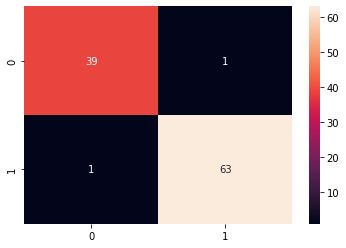

In [16]:
gb = GradientBoostingClassifier(n_estimators = 100, max_features = 'sqrt', max_depth= 8, learning_rate = 0.25)
gb.fit(X_train,y_train.values.ravel())
%timeit y_pred = gb.predict(X_test)
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot = True)

1.34 ms ± 198 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        40
         1.0       0.98      0.98      0.98        64

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104



<AxesSubplot:>

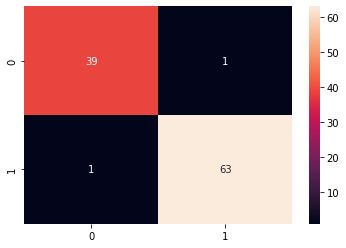

In [17]:
xgbc = XGBClassifier(subsample = 0.9, n_estimators = 100, max_depth = 7, learning_rate = 0.1, colsample_bytree = 0.7)
xgbc.fit(X_train,y_train.values.ravel())
%timeit y_pred = xgbc.predict(X_test)
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot = True)

18.7 ms ± 2.36 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        40
         1.0       0.98      0.98      0.98        64

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104



<AxesSubplot:>

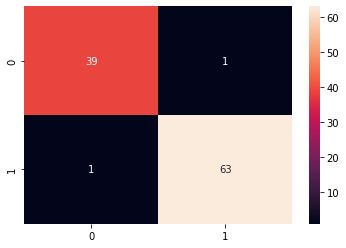

In [18]:
rf = RandomForestClassifier(max_features = 'log2', max_depth = 9, criterion = 'entropy')
rf.fit(X_train,y_train.values.ravel())
%timeit y_pred = rf.predict(X_test)
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot = True)

All three models built result in same confusion matrix, with 1 false positive and 1 false negative, and 39 true negative and 63 true positive. So from the perspective of prediction power, they are on the same level.
<br> If speed matters for any reason, we can pick XGBoost over the other 2, since it's much faster on both training model and also predicting diabetes.

6. XGB ROC Analysis and feature importance

In [19]:
xgbc = XGBClassifier(subsample = 0.9, n_estimators = 100, max_depth = 7, learning_rate = 0.1, colsample_bytree = 0.7)
xgbc.fit(X_train,y_train.values.ravel())
y_pred = xgbc.predict(X_test)

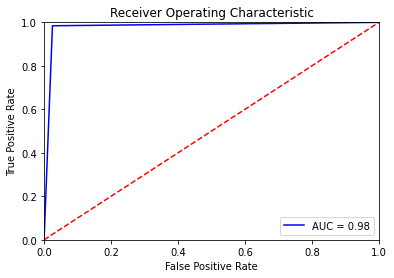

In [20]:
fpr, tpr, threshold = roc_curve(y_test,y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
for feat, importance in zip(X_train.columns, rf.feature_importances_):
    print('feature: {f}, importance: {i}'.format(f=feat, i=importance))

feature: Age, importance: 0.10719292321775996
feature: Gender, importance: 0.08109792505219954
feature: Polyuria, importance: 0.1947158589069501
feature: Polydipsia, importance: 0.17100242242377803
feature: sudden weight loss, importance: 0.06500163013915783
feature: weakness, importance: 0.02955502090196403
feature: Polyphagia, importance: 0.032460002381417274
feature: Genital thrush, importance: 0.02366980004170422
feature: visual blurring, importance: 0.03671926783988968
feature: Itching, importance: 0.03564103156379811
feature: Irritability, importance: 0.04311945433860169
feature: delayed healing, importance: 0.03682940841759125
feature: partial paresis, importance: 0.04138270884497973
feature: muscle stiffness, importance: 0.030261760770175835
feature: Alopecia, importance: 0.048292089217218254
feature: Obesity, importance: 0.02305869594281449


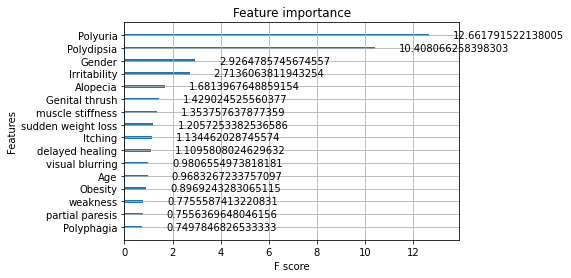

In [52]:
# 1st way to get feature importance
from xgboost import plot_importance
plot_importance(xgbc,importance_type = 'gain')
plt.show()

<AxesSubplot:>

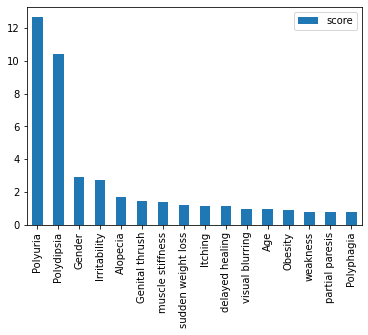

In [50]:
# 2nd way to get feature importance
feature_importance = xgbc.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='bar')

<AxesSubplot:>

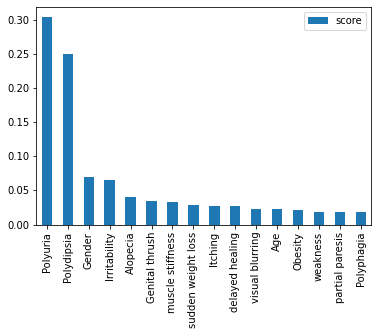

In [49]:
#3rd way to get feature importance
df = pd.DataFrame(data=xgbc.feature_importances_, index=X_train.columns, columns=["score"])\
    .sort_values(by = "score", ascending=False)
df.plot(kind='bar')

Polyuria and Polydipsia are two most important factors to detect Diabetes. 'Gain' approach is used to determine feature importance*
* Gain approach represents the average gain across all splits where feature was used. 
* Weight approach represents the number of times feature was used for split; it favors high cardinality and numeric features

This is the final notebook of the Diabetes Early Prediction Case Study. 
4 different models are trained and best hyperparameters are selected; XGB Classifier is selected in the end due to its high recall, high accuracy, high precision, as well as faster speed in both training and predicting.